In [1]:
# Import libraries
%load_ext autoreload
#%autoreload 2

import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from IPython.display import display, HTML, Latex, Image
from IPython.display import Markdown as md
from IPython.core.magic import register_cell_magic
from tabulate import tabulate
from sklearn.linear_model import LinearRegression
import mercury as mr

# Allow for markdown code cells
@register_cell_magic
def markdown(line, cell):
    return md(cell.format(**globals()))

# Set the Mercurty metadata forthe report
app = mr.App(title="Lab 4", description="Lab report for PHYS 2125 (15921) Spring 2025 Lab 4.")

# Request Data
name = mr.Text(value="Your Name", label="What is your name?", rows=1)
course = mr.Text(value="PHYS 2125 (15921)", label="What class are you in?", rows=1)
date = mr.Text(value="2025-02-07", label="Lab Date", rows=1)
labNum = mr.Text(value="4", label="Lab Number", rows=1)
labName = mr.Text(value="Hooke's Law", label="Lab Name", rows=1)
file = mr.File(label="Data file upload", max_file_size="10MB")
skip1 = mr.Checkbox(value=False, label="Were you instructed to exclude your first trial from the calculations?")
# It would be cooler if we could get the discussion questions into a dict and loop through them.
dq1 = mr.Text(value="Question 1 Answer", label="Explain the two reasons for not getting % difference close to zero. (3 pts)", rows=5)
dq2 = mr.Text(value="Question 2 Answer", label="What was the most difficult measurement to make during this experiment? (3 pts)", rows=5)
dq3 = mr.Text(value="Question 4 Answer", label="Why did you take two x-values for each mass? (4 pts)", rows=5)
plt1_xaxis = mr.Text(value = '$x\; (m)$', label="X-axis label", rows=1)
plt1_yaxis = mr.Text(value = '$M_H\; (kg)$', label="Y-axis label", rows=1)
plt1_title = mr.Text(value = '$Hanging\; mass\; (M_H)\; vs\; spring\; elongation\; (x)$', label="Graph title", rows=1)

mercury.App

mercury.Text

mercury.Text

mercury.Text

mercury.Text

mercury.Text

mercury.File

mercury.Checkbox

mercury.Text

mercury.Text

mercury.Text

mercury.Text

mercury.Text

mercury.Text

In [2]:

# Parse Data
dataColumnNames = ["M_a (kg)", "M_h (kg)", "M_H (kg)", "M_H g (N)", "x_1 (m)", "x_x (m)", "x_avg (m)", "k (N/m)"];

if file.filepath is not None:
    df = pd.read_csv(file.filepath, names=dataColumnNames, header=0).set_index(dataColumnNames[0])
else:
    df = pd.read_csv('lab4.csv', names=dataColumnNames, header=0).set_index(dataColumnNames[0])

# Do Calculations (Python)
# In theory the data we uploaded already has lots of these values, but just in case the Excel wasn't perfect we're going to do it here.

# Constants
g_earth = 9.8;

# Calculate M_H as M_h + M_a, but only where we have a number for M_a
df[dataColumnNames[2]] = df.apply(lambda row: float(row.name) + row[dataColumnNames[1]] if re.match(r'^-?\d+(?:\.\d+)$',row.name) is not None else None, axis=1)

# Recalculate M_H g
df[dataColumnNames[3]] = df.apply(lambda row: row[dataColumnNames[2]] * g_earth if isinstance(row[dataColumnNames[2]], (int, float)) else None, axis=1)

# Recaulcate x_avg
df[dataColumnNames[6]] = df.apply(lambda row: ( row[dataColumnNames[4]] + row[dataColumnNames[5]] ) / 2, axis=1)

# Recalculate k, but only where M_H is set.
df[dataColumnNames[7]] = df.apply(lambda row: row[dataColumnNames[3]] / row[dataColumnNames[6]] if isinstance(row[dataColumnNames[2]], (int, float)) else None, axis=1)

# Save this for the table
data_html = df.fillna('').to_html();

# Save x_unknown
x_u = df.iat[-1, 5];

# Remove the M_unknown row so that we can use the rest of the data frame for the other calculations
df = df.drop(df.index[-1])

# Delete the first row if we're not including that in the calculations
if skip1.value:
    df = df.drop(df.index[0])

# Calculate the trend line slope and intercept
trend = np.polyfit(df[dataColumnNames[6]], df[dataColumnNames[3]], 1)  # 1 for linear trendline
trend_slope, trend_intercept = trend

# - Use the equation of the line to get $k_g$
k_g = trend_slope

# Mean and StdDev across the board
mean = df.mean()
deviation = df.std(ddof=0)

# - Calculate average $k$ from the table, $k_t$ (using data points 1-6, not the unknown mass)
k_t = mean[dataColumnNames[7]];

#- Calculate M_unknown using $k_t$
# Extra information - how to calculate M_unknown using table: M_unknown_t = ( ( ( k_t * x_unknown ) /g ) -0.005 )
m_k_t = ( ( k_t * x_u ) / g_earth ) - 0.005

#- Calculate M_unknown using $k_g$
# M_unknown from the graph (same thing, using k_g) (y-value of intercept with trendline): ( ( M_unknown_t / g ) -0.005 )
m_int_y = (x_u) * k_g + trend_intercept
m_k_g = ( m_int_y / g_earth ) -0.005 

# Calculate % difference between k_table and k_graph
k_diff = abs( k_g - k_t ) / ( ( k_t + k_g ) / 2 )

# Calculate % difference m_unknown_table and m_unknown_graph
m_diff = abs( m_k_g - m_k_t ) / ( ( m_k_t + m_k_g ) / 2 )

# - Complete the graph with all the details
# $g = 9.8 m/s/s$
# slope of the line is $k$

# Let's make some stings
x_u_str = str("%.2f" % round(x_u, 2))
k_g_str = str("%.2f" % round(k_g, 2))
k_t_str = str("%.2f" % round(k_t, 2))
m_k_t_str = str("%.4f" % round(m_k_t, 4))
m_k_g_str = str("%.4f" % round(m_k_g, 4))
k_diff_str = str("%.2f" % round(k_diff*100, 2))
m_diff_str = str("%.2f" % round(m_diff*100, 2))
trend_slope_str = str("%.2f" % round(trend_slope, 2))
trend_intercept_str = str("%.2f" % round(trend_intercept, 2))

In [3]:
%%markdown

# Lab {labNum.value}: {labName.value}
Name: **{name.value}** \
Class: **{course.value}** \
Date: **{date.value}**

<p style="page-break-after:always;"></p>


# Lab 4: Hooke's Law
Name: **Your Name** \
Class: **PHYS 2125 (15921)** \
Date: **2025-02-07**

<p style="page-break-after:always;"></p>


- [ ] TODO: Show the math in LaTex? Walk through all the math in a more ordered way? (LaTeX)
- [ ] TODO: final edits

## Objective

To determine the spring constant and the unknown mass using Hooke's law.

## Equipment

- (1) small A-base
- (1) long metal rod
- (1) clamp
- (1) short rod
- (1) spring set
  - (1) "medium strength" spring with unknown $k$ value
  - (1) 5g hook
- (1) set of weights with known masses
- (1) weight of unknown mass
- (1) 1 meter ruler

<p style="page-break-after:always;"></p>

## Theory

The downward force of a weight, $F_a$, can be calculated per the equation

$F_a = M_H g$

where $M_H$ is the mass of the weight and $g$ is the gravitational constant of the Earth.

This force can also be calculated per the equation

$F_a = k x$

where $k$ is the spring constant of the spring in question and $x$ is the amount of elongation of the spring.

Because of Newton's third law we know that the force exerted on the spring, $F_s$ is the opposite of $F_a$, such that $F_s = - F_a$.

Together can be rewritten as *Hooke's law*:

$F_s = -kx$

We can leverage these two relationships to derive a third, allowing us to relate the mass of a weight, $M_H$, directly to the spring constant, $k$.

$M_H g = kx$

In a two step process we will use weights of a known mass and a spring of an unknown $k$ value to calculate the mass of a weight of unknown mass.

1. By using a variety of different weights of known mass we will determine the spring constant, $k$ of the spring we are using.
1. With $k$ determined we will then use Hooke's law to to determine the mass of the unknown weight.

Note: we are using a 5g hook to suspend the weights, and as such $M_H$ will be calculated per

$M_H = M_h + M_a$

where $M_H$ is the 5g mass of the hook and $M_a$ is the weight of the mass added in that trial.

In [4]:
display(Image(url='https://raw.githubusercontent.com/dundonite/Physics-Lab-2125-15921/refs/heads/main/lab4.png', width=500))

<p style="page-break-after:always;"></p>

## Procedure

The following procedure was followed.

### Initial Setup

The pendulum was constructed as follows.

1. A small cast iron A-base was placed on the table.
1. A 45cm steel rod was secured into the A-frame, raised up as much as possible to maximize the height.
1. The vertical mounting side of a steel clamp was secured at the very top of the rod.
1. A 15cm rod was attached to the horizontal side of the same steel clamp, to the far end of the smaller rod.
1. A spring with an unknown $k$ value was supsended from the small rod, opposite the clamp.

### Trial (completed for each $M_a$)

Each measurement was conducted twice and measured as $x_1$ and $x_2$.

1. A 25g weight was attached to the hook, and $x$ was recorded.
1. Weight was increased in 5g increments through 50g, with $x$ recorded for each.
1. The weight of unknown mass was placed on the hook, and again the elongation, $x$ was measured.

<p style="page-break-after:always;"></p>

## Data

In [5]:
# Print the data table
HTML(data_html)

,M_h (kg),M_H (kg),M_H g (N),x_1 (m),x_x (m),x_avg (m),k (N/m)
M_a (kg),,,,,,,
0.025,0.005,0.03,0.294,0.21,0.19,0.200,1.47
0.03,0.005,0.035,0.343,0.31,0.28,0.295,1.162712
0.035,0.005,0.04,0.392,0.41,0.39,0.400,0.98
0.04,0.005,0.045,0.441,0.51,0.50,0.505,0.873267
0.045,0.005,0.05,0.49,0.61,0.59,0.600,0.816667
0.05,0.005,0.055,0.539,0.71,0.70,0.705,0.764539
M_Unknown,0.005,,,0.50,0.49,0.495,


In [6]:
if skip1.value:
    display(md("_Note: the first trial was excluded from the calculations as a likely error._"))

<p style="page-break-after:always;"></p>

## Calculations

In [7]:
# Show the math? (LaTeX)

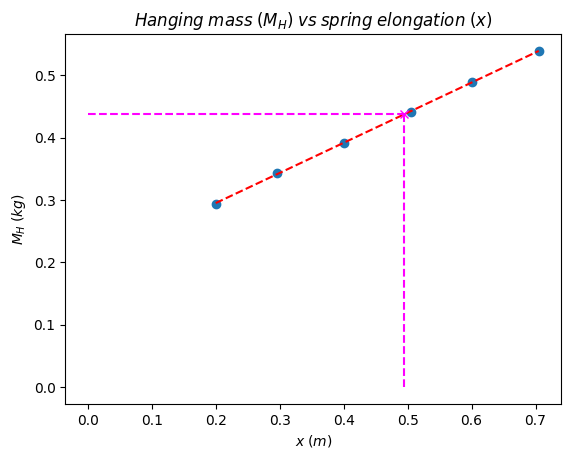

In [8]:
# We should figure out a way to deifne the chart details in the calculations section such that this section can remain static.

# - Complete the graph with all the details
# $M_H g$ in the y-axis (Newtons)
# $g = 9.8 m/s/s$
# $x$ in the x-axis
# slope of the line is $k$

# Turn off interactive so we can print later
#plt.ioff()

# Plot the measurements
plt.scatter(df[dataColumnNames[6]], df[dataColumnNames[3]]);

# Plot the trendline - there must be a way to use the trendline calculation from earlier but idk Python
p = np.poly1d(np.polyfit(df[dataColumnNames[6]], df[dataColumnNames[3]], 1));
plt.plot(df[dataColumnNames[6]], p(df[dataColumnNames[6]]), "r--");

# Add intercept lines for M_H
plt.plot(x_u, m_int_y, marker="x", color="magenta");
plt.vlines(x_u, 0, m_int_y, color="magenta", linestyle="--");
plt.hlines(m_int_y, 0, x_u, color="magenta", linestyle="--");

# Add labels w LaTeX support
plt.xlabel(plt1_xaxis.value);
plt.ylabel(plt1_yaxis.value);
plt.title(plt1_title.value);
plt.rcParams['text.usetex'] = True;
plt.rcParams['font.family'] = 'serif';

# Show the graph
plt.show();

# - Calculate average $k$ from the table, $k_t$ (using data points 1-6, not the unknown mass)

# - Use the equation of the line to get $k_g$
#- Calculate M_unknown using $k_t$
# Extra information - how to calculate M_unknown using table: M_unknown_t = ( ( ( k_t * x_unknown ) /g ) -0.005 )
#- Calculate M_unknown using $k_g$
# M_unknown from the graph (same thing, using k_g) (y-value of intercept with trendline): ( ( M_unknown_t / g ) -0.005 )
# Calculate % difference between k_table and k_graph
# Calculate % difference m_unknown_table and m_unknown_graph

In [9]:
%%markdown

Using the least squares method a trend line is fit to the data with *slope* {trend_slope_str} and *$y$-intercept* {trend_intercept_str}, resulting in the equation $ y = {trend_slope_str} x + {trend_intercept_str} $.


Using the least squares method a trend line is fit to the data with *slope* 0.48 and *$y$-intercept* 0.20, resulting in the equation $ y = 0.48 x + 0.20 $.


In [10]:
%%markdown

<p style="page-break-after:always;"></p>

## Results

The value of $k$ was determined using the mean, $k_t$, and the least squares fit, $k_g$.

$k_g = {k_g_str}$ 

$k_t = {k_t_str}$

This equates to a ${k_diff_str}$% difference.

These mass of the unknown weight was then calculated as $M_t$ and $M_g$ using $k_t$ and $k_g$ respectively.

$M_g = {m_k_g_str}kg$

$M_t = {m_k_t_str}kg$

This equates to a ${m_diff_str}$% difference.


<p style="page-break-after:always;"></p>

## Results

The value of $k$ was determined using the mean, $k_t$, and the least squares fit, $k_g$.

$k_g = 0.48$ 

$k_t = 1.01$

This equates to a $70.58$% difference.

These mass of the unknown weight was then calculated as $M_t$ and $M_g$ using $k_t$ and $k_g$ respectively.

$M_g = 0.0397kg$

$M_t = 0.0461kg$

This equates to a $14.92$% difference.


<p style="page-break-after:always;"></p>

## Discussion




In [11]:
%%markdown

__Explain the two reasons for not getting % difference close to zero. (3 pts)__

{dq1.value}

__What was the most difficult measurement to make during this experiment? (3 pts)__

{dq2.value}

__Why did you take two x-values for each mass? (4 pts)__

{dq3.value}


__Explain the two reasons for not getting % difference close to zero. (3 pts)__

Question 1 Answer

__What was the most difficult measurement to make during this experiment? (3 pts)__

Question 2 Answer

__Why did you take two x-values for each mass? (4 pts)__

Question 4 Answer
